# Redes sociais - P1
Fernando Fincatti, Gabriela Moreno, Gabriella Cukier e Manuel Castanares

---

### Importando bibliotecas
---

In [1]:
import netpixi
from netpixi.data.gt import *
import cpnet
from graph_tool import spectral
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
sns.set()
from matplotlib import rcParams
import statsmodels.formula.api as smf
import csv
import pandas as pd
from graph_tool import util
from graph_tool import Graph
from utils import *
from graph_tool import clustering

import seaborn as sns
sns.set()

### Carrega dados
---

In [2]:
#carrega dados
df = pd.read_csv('athlete_events.csv')
df_noc = pd.read_csv('noc_regions.csv')
df_gdp = pd.read_csv('countries of the world.csv')

In [3]:
df_gdp.head(2)

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"


In [4]:
#junta ambas as tabelas
df_merge=df.merge(df_noc,how="left",on="NOC")

#dropa linhas sem a região
df_merge=df_merge.dropna(subset=['region'])

In [5]:
df_merge.head(2)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,China,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,China,NaN


### Amostragem
---

In [6]:
#filtra somente datas posteriores a 1970
df_merge=df_merge[df_merge["Year"] > 1970]

### Análise
---

In [7]:
#cria grafo não-dirigido
g = Graph(directed=False)
c = Graph(directed=False) 

In [8]:
df_merge['desempenho'] = df_merge['Medal'].apply(lambda x: desempenho(x))

In [9]:
#dropa valores duplicados
df_desempenho = df_merge.drop_duplicates(subset=["Year","Sport","region"])

#remove paises com desempenho 0
df_desempenho = df_desempenho.loc[df_desempenho.desempenho>0]

In [10]:
#pega o desempenho por país por esporte
df_desempenho_pais = df_desempenho[["Sport", "region", "desempenho"]].groupby(["Sport", "region"], as_index=False).sum()

#calcula o desemepnho médio por esporte
df_desempenho_media = df_desempenho_pais.groupby(["Sport"]).mean()

In [11]:
#adiciona o desempenho médio por esporte na tabela
df_desempenho_pais["media"] = df_desempenho_pais["Sport"].apply(lambda x: 
              media(x, df_desempenho_media))

In [12]:
#ajusta nome dos países na tabela
df_gdp['Country'] = df_gdp['Country'].apply(lambda x: elimina_ultimo_caracter(x))

In [13]:
#dicionário com os nomes corretos
dic_paises_nome = {
    'South Korea': 'Korea, South',
    'USA': 'United States',
    'UK': 'United Kingdom',
    'North Korea': 'Korea, North',
    'Ivory Coast': "Cote d'Ivoire"
}

In [14]:
#acerta o nome dos países
df_desempenho_pais['region'] = df_desempenho_pais['region'].apply(lambda x: acerta_nome_paises(x, dic_paises_nome)) 

In [15]:
#pega informações sobre cada país
df_desempenho_pais = df_desempenho_pais.merge(df_gdp[["Country","GDP ($ per capita)"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country",)

In [16]:
#remove alguns países irrelevantes
df_desempenho_pais = df_desempenho_pais.dropna(subset=['GDP ($ per capita)'])

In [17]:
df_desempenho_pais.head()

,Sport,region,desempenho,media,Country,GDP ($ per capita)
0,Alpine Skiing,Australia,1,1.857143,Australia,29000.0
1,Alpine Skiing,Austria,3,1.857143,Austria,30000.0
2,Alpine Skiing,Czech Republic,1,1.857143,Czech Republic,15700.0
3,Alpine Skiing,France,2,1.857143,France,27600.0
4,Alpine Skiing,New Zealand,2,1.857143,New Zealand,21600.0


In [18]:
#pega todos os times
lista_teams = df_desempenho_pais.region.unique().tolist()

#pega todos os eventos
lista_eventos = df_desempenho_pais.Sport.unique().tolist()

In [19]:
g.vp['tipo'] = g.new_vp('object')
g.vp['nome'] = g.new_vp('object')
g.vp['color'] = g.new_vp('object')

In [20]:
lista_vertices = lista_teams+lista_eventos

In [21]:
#cria os times como vértices
cria_vertices(g, lista_vertices, len(lista_teams))
print('número de vértices de g:', g.num_vertices())

número de vértices de g: 148


In [22]:
lista_arestas = list()

#preenche a lista e o dicionario de acordo com as partidas e ocorrencias
df_fake = df_desempenho_pais.apply(lambda x: 
              arestas(x.region, x.Sport, x.desempenho, x.media, lista_arestas),
              axis=1)

In [23]:
create_edgs_links(lista_arestas, g)

### Análise 2
---

In [24]:
c.vp['nome'] = c.new_vp('object') #adiciona propriedade aos vértices
c.ep['peso'] = c.new_ep('object') #adiciona propriedade as arestas

In [25]:
cria_nome_times(g, c) #cria vertíces

In [26]:
dicionario_one_mode, lista_one_mode = lista_esporte_por_time(g)

In [27]:
dist = cria_arestas(c, dicionario_one_mode, lista_one_mode)

### Visualizando grafo C
---

In [28]:
m = draw_gt.sfdp_layout(c)
move_gt(c, m)

In [29]:
save_gt(c, 'exemplo_c.net.gz')

In [30]:
r = netpixi.render('./exemplo_c.net.gz', infinite=True)

In [31]:
# mudar a cor de fundo do grafo
r.graph(color=0xffffff)

# mudar a cor e o tamanho dos vértices
r.vertex_default(color=0x05445E, size=15)

# mudar a cor, a espessura e a curvatura das arestas
r.edge_default(color=0xB1D4E0, width=1, curve1=0, curve2=0)


r.graph(kscale=5) # Isto aumenta o tamanho dos nomes.
r.vertex_default(size=6)
r.vertex_set_key('nome')
r.edge_scale('peso', 1, 3)

### Cluster coefficient
---

In [32]:
cluster = clustering.local_clustering(c)

In [33]:
c.vp['clustering coefficient'] = cluster

In [34]:
dft = pd.DataFrame({k: list(v) for k, v in c.vp.items()})

In [35]:
dft = dft.loc[dft['clustering coefficient'] != 0]

### Salvando grafo e visualizando
---

In [36]:
top = []
for v in g.vertices():
    if g.vp['tipo'][v] == 'time':
        top.append(v)

In [37]:
m = draw_gt.bipartite_layout(g, top)
move_gt(g, m)

In [38]:
save_gt(g, 'exemplo.net.gz')

In [39]:
r = netpixi.render('./exemplo.net.gz')

In [40]:
# mudar a cor de fundo do grafo
r.graph(color=0xffffff)

# mudar a cor e o tamanho dos vértices
r.vertex_default(color=0x000000, size=10)

# mudar a cor, a espessura e a curvatura das arestas
r.edge_default(color=0x000000, width=1, curve1=0, curve2=0)

# mudar uma aresta específica a partir dos ids de sua origem e destino
r.edge(0, 1, color=0x0000ff, width=2)

r.graph(kscale=0.5) # Isto aumenta o tamanho dos nomes.
r.vertex_default(size=6)
r.vertex_set_key('nome')
r.edge_scale('peso', 1, 3)

### Regressão
---

In [41]:
df_desempenho

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes,desempenho
40,16,Juhamatti Tapio Aaltonen,M,28.0,184.0,85.0,Finland,FIN,2014 Winter,2014,Winter,Sochi,Ice Hockey,Ice Hockey Men's Ice Hockey,Bronze,Finland,NaN,1
63,20,Kjetil Andr Aamodt,M,22.0,176.0,85.0,Norway,NOR,1994 Winter,1994,Winter,Lillehammer,Alpine Skiing,Alpine Skiing Men's Downhill,Silver,Norway,NaN,2
79,21,Ragnhild Margrethe Aamodt,F,27.0,163.0,NaN,Norway,NOR,2008 Summer,2008,Summer,Beijing,Handball,Handball Women's Handball,Gold,Norway,NaN,3
91,29,Willemien Aardenburg,F,22.0,NaN,NaN,Netherlands,NED,1988 Summer,1988,Summer,Seoul,Hockey,Hockey Women's Hockey,Bronze,Netherlands,NaN,1
92,30,Pepijn Aardewijn,M,26.0,189.0,72.0,Netherlands,NED,1996 Summer,1996,Summer,Atlanta,Rowing,Rowing Men's Lightweight Double Sculls,Silver,Netherlands,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247957,124148,Wietse Cornelis van Alten,M,21.0,186.0,72.0,Netherlands,NED,2000 Summer,2000,Summer,Sydney,Archery,Archery Men's Individual,Bronze,Netherlands,NaN,1
248235,124277,Robert Van de Walle,M,26.0,187.0,95.0,Belgium,BEL,1980 Summer,1980,Summer,Moskva,Judo,Judo Men's Half-Heavyweight,Gold,Belgium,NaN,3
254146,127250,Gintar Volungeviit-Scheidt,F,25.0,172.0,63.0,Lithuania,LTU,2008 Summer,2008,Summer,Beijing,Sailing,Sailing Women's One Person Dinghy,Silver,Lithuania,NaN,2
260747,130468,David Robert Wilkins,M,30.0,175.0,75.0,Ireland,IRL,1980 Summer,1980,Summer,Moskva,Sailing,Sailing Mixed Two Person Heavyweight Dinghy,Silver,Ireland,NaN,2


## Separando os esportes em grupo e individuais

In [42]:
individual_sports = [
    "Alpine Skiing",
    "Rowing",
    "Fencing",
    "Taekwondo",
    "Athletics",
    "Canoeing",
    "Wrestling",
    "Sailing",
    "Cycling",
    "Boxing",
    "Nordic Combined",
    "Gymnastics",
    "Bobsleigh",
    "Judo",
    "Swimming",
    "Tennis",
    "Skating",
    "Weightlifting",
    "Badminton",
    "Shooting",
    "Diving",
    "Biathlon",
    "Pentathlon",
    "Luge",
    "Snowboarding",
    "Skiing",
    "Ski",
    "Trampolining",
    "Triathlon",
    "Archery"
]
individual_events=[]
group_events=[]

list_events = df_desempenho.Event.values
for e in list_events:
    if any(sports in e for sports in individual_sports):
        individual_events.append(e)
    else:
        group_events.append(e)

## Esportes em grupo

In [43]:
df_desempenho_group = df_desempenho[df_desempenho['Event'].isin(group_events)]

In [44]:
df_desempenho_pais_total = df_desempenho_group[["region", "desempenho"]].groupby(["region"], as_index=False).sum()

In [45]:
df_desempenho_pais_total = df_desempenho_pais_total.merge(df_gdp[["Country","GDP ($ per capita)"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country")

df_desempenho_pais_total = df_desempenho_pais_total.merge(dft,
                                              how='left',
                                              left_on="region",
                                              right_on="nome")

In [46]:
df_desempenho_pais_total.head()

,region,desempenho,Country,GDP ($ per capita),nome,_x,_y,clustering coefficient
0,Argentina,19,Argentina,11200.0,Argentina,7.673247,6.228421,0.792075
1,Australia,25,Australia,29000.0,Australia,10.696573,4.080148,0.679000
2,Austria,3,Austria,30000.0,Austria,8.161533,8.221446,0.874191
3,Belgium,3,Belgium,29100.0,Belgium,11.922714,6.839597,0.787561
4,Brazil,34,Brazil,7600.0,Brazil,9.598687,6.502751,0.770852


In [47]:
#pega informações sobre cada país
df_desempenho_pais_total = df_desempenho_pais_total.merge(df_gdp[["Country","Population"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country",)

In [48]:
df_desempenho_pais_total['y'] = df_desempenho_pais_total['GDP ($ per capita)']
df_desempenho_pais_total['c'] = df_desempenho_pais_total['clustering coefficient']
df_desempenho_pais_total['pop'] = df_desempenho_pais_total['Population']

In [49]:
model = smf.ols(data=df_desempenho_pais_total, formula='desempenho ~ y')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.8391
Date:                Sat, 27 Nov 2021   Prob (F-statistic):              0.365
Time:                        01:10:44   Log-Likelihood:                -183.87
No. Observations:                  44   AIC:                             371.7
Df Residuals:                      42   BIC:                             375.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.2089      4.199      2.669      0.011       2.735      19.683
y              0.0002      0.000      0.916      0.365      -0.000       0.001
==============================================================================
Omnibus:                       47.991   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              228.176
Skew:                           2.680   Prob(JB):                     2.83e-50
Kurtosis:                      12.784   Cond. No.                     3.33e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.33e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

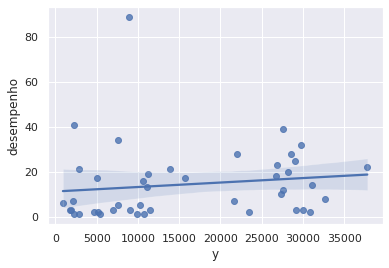

In [50]:
sns.regplot(x=df_desempenho_pais_total['y'], y=(df_desempenho_pais_total['desempenho']))
plt.show()

In [51]:
df_desempenho

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes,desempenho
40,16,Juhamatti Tapio Aaltonen,M,28.0,184.0,85.0,Finland,FIN,2014 Winter,2014,Winter,Sochi,Ice Hockey,Ice Hockey Men's Ice Hockey,Bronze,Finland,NaN,1
63,20,Kjetil Andr Aamodt,M,22.0,176.0,85.0,Norway,NOR,1994 Winter,1994,Winter,Lillehammer,Alpine Skiing,Alpine Skiing Men's Downhill,Silver,Norway,NaN,2
79,21,Ragnhild Margrethe Aamodt,F,27.0,163.0,NaN,Norway,NOR,2008 Summer,2008,Summer,Beijing,Handball,Handball Women's Handball,Gold,Norway,NaN,3
91,29,Willemien Aardenburg,F,22.0,NaN,NaN,Netherlands,NED,1988 Summer,1988,Summer,Seoul,Hockey,Hockey Women's Hockey,Bronze,Netherlands,NaN,1
92,30,Pepijn Aardewijn,M,26.0,189.0,72.0,Netherlands,NED,1996 Summer,1996,Summer,Atlanta,Rowing,Rowing Men's Lightweight Double Sculls,Silver,Netherlands,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247957,124148,Wietse Cornelis van Alten,M,21.0,186.0,72.0,Netherlands,NED,2000 Summer,2000,Summer,Sydney,Archery,Archery Men's Individual,Bronze,Netherlands,NaN,1
248235,124277,Robert Van de Walle,M,26.0,187.0,95.0,Belgium,BEL,1980 Summer,1980,Summer,Moskva,Judo,Judo Men's Half-Heavyweight,Gold,Belgium,NaN,3
254146,127250,Gintar Volungeviit-Scheidt,F,25.0,172.0,63.0,Lithuania,LTU,2008 Summer,2008,Summer,Beijing,Sailing,Sailing Women's One Person Dinghy,Silver,Lithuania,NaN,2
260747,130468,David Robert Wilkins,M,30.0,175.0,75.0,Ireland,IRL,1980 Summer,1980,Summer,Moskva,Sailing,Sailing Mixed Two Person Heavyweight Dinghy,Silver,Ireland,NaN,2


### Conclusão
---

Com base na regressão feita acima, podemos ver que o coeficiente é muito pequeno. O $R^2$ obtido também é muito pequeno, mostrando que não há um bom fit entre as duas variáveis. Além disso, os valores para o eixo X (desempenho) também são muito parecidos, o que faz o gráfico ficar "empilhado", isso é possível confirmar apartir da visualização acima. Portanto podemos rejeitar a hipótese de que mais riqueza signifca mais desempenho.

## Clustering Coefficient X Desempenho

In [52]:
df_desempenho_cluster = df_desempenho_pais_total.dropna(subset=['clustering coefficient'])

In [53]:
model = smf.ols(data=df_desempenho_cluster, formula='desempenho ~ c')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     17.92
Date:                Sat, 27 Nov 2021   Prob (F-statistic):           0.000123
Time:                        01:10:44   Log-Likelihood:                -176.49
No. Observations:                  44   AIC:                             357.0
Df Residuals:                      42   BIC:                             360.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     66.1071     12.401      5.331      0.000      41.080      91.134
c            -65.7222     15.526     -4.233      0.000     -97.055     -34.390
==============================================================================
Omnibus:                       37.277   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.058
Skew:                           2.037   Prob(JB):                     4.70e-30
Kurtosis:                      10.555   Cond. No.                         12.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

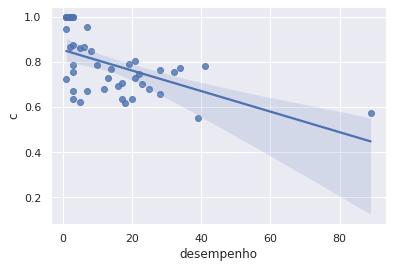

In [54]:
sns.regplot(x=df_desempenho_cluster['desempenho'], y=df_desempenho_cluster['c'])
plt.show()

### Análise com variáveis de controle

#### Desempenho X (Clustering Coefficient + GDP)

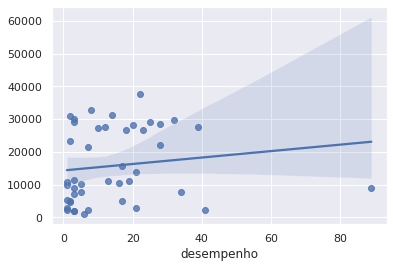

In [55]:
sns.regplot(x=df_desempenho_cluster['desempenho'], y=(df_desempenho_cluster['c'] + (df_desempenho_cluster['y'])))
plt.show()

In [56]:
model = smf.ols(data=df_desempenho_cluster, formula='desempenho ~ y+c+pop')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     5.721
Date:                Sat, 27 Nov 2021   Prob (F-statistic):            0.00235
Time:                        01:10:45   Log-Likelihood:                -176.45
No. Observations:                  44   AIC:                             360.9
Df Residuals:                      40   BIC:                             368.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     68.1654     14.953      4.559      0.000      37.944      98.387
y          -5.424e-05      0.000     -0.263      0.794      -0.000       0.000
c            -67.1767     16.835     -3.990      0.000    -101.201     -33.152
pop        -6.512e-10   8.85e-09     -0.074      0.942   -1.85e-08    1.72e-08
==============================================================================
Omnibus:                       35.516   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.799
Skew:                           1.937   Prob(JB):                     2.16e-27
Kurtosis:                      10.209   Cond. No.                     2.80e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.8e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Esportes individuais

In [57]:
df_desempenho_group = df_desempenho[df_desempenho['Event'].isin(individual_events)]

In [58]:
df_desempenho_pais_total = df_desempenho_group[["region", "desempenho"]].groupby(["region"], as_index=False).sum()

In [59]:
df_desempenho_pais_total = df_desempenho[["region", "desempenho"]].groupby(["region"], as_index=False).sum()

In [60]:
df_desempenho_pais_total = df_desempenho_pais_total.merge(df_gdp[["Country","GDP ($ per capita)"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country")

df_desempenho_pais_total = df_desempenho_pais_total.merge(dft,
                                              how='left',
                                              left_on="region",
                                              right_on="nome")

In [61]:
df_desempenho_pais_total.head()

,region,desempenho,Country,GDP ($ per capita),nome,_x,_y,clustering coefficient
0,Algeria,1,Algeria,6000.0,Algeria,10.281086,1.444060,1.000000
1,Argentina,26,Argentina,11200.0,Argentina,7.673247,6.228421,0.792075
2,Armenia,5,Armenia,3500.0,Armenia,10.936980,0.273306,1.000000
3,Australia,82,Australia,29000.0,Australia,10.696573,4.080148,0.679000
4,Austria,25,Austria,30000.0,Austria,8.161533,8.221446,0.874191


In [62]:
#pega informações sobre cada país
df_desempenho_pais_total = df_desempenho_pais_total.merge(df_gdp[["Country","Population"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country",)

In [63]:
df_desempenho_pais_total['y'] = df_desempenho_pais_total['GDP ($ per capita)']
df_desempenho_pais_total['c'] = df_desempenho_pais_total['clustering coefficient']
df_desempenho_pais_total['pop'] = df_desempenho_pais_total['Population']

In [64]:
model = smf.ols(data=df_desempenho_pais_total, formula='desempenho ~ y')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     17.99
Date:                Sat, 27 Nov 2021   Prob (F-statistic):           5.33e-05
Time:                        01:10:45   Log-Likelihood:                -459.55
No. Observations:                  93   AIC:                             923.1
Df Residuals:                      91   BIC:                             928.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.1337      5.308      1.344      0.182      -3.410      17.678
y              0.0015      0.000      4.241      0.000       0.001       0.002
==============================================================================
Omnibus:                      112.319   Durbin-Watson:                   1.780
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2196.977
Skew:                           3.948   Prob(JB):                         0.00
Kurtosis:                      25.464   Cond. No.                     2.25e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

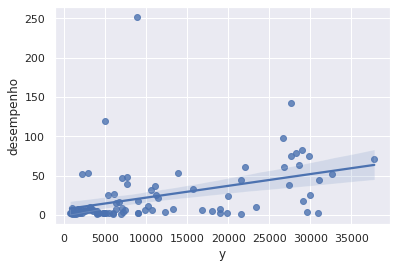

In [65]:
sns.regplot(x=df_desempenho_pais_total['y'], y=(df_desempenho_pais_total['desempenho']))
plt.show()

### Conclusão
---

In [66]:
df_desempenho_pais_filtered = df_desempenho_pais_total[df_desempenho_pais_total['desempenho']>80]
df_desempenho_pais_filtered

,region,desempenho,Country_x,GDP ($ per capita),nome,_x,_y,clustering coefficient,Country_y,Population,y,c,pop
3,Australia,82,Australia,29000.0,Australia,10.696573,4.080148,0.679000,Australia,2.026408e+07,29000.0,0.679000,2.026408e+07
14,China,120,China,5000.0,China,10.026358,4.236053,0.635322,China,1.313974e+09,5000.0,0.635322,1.313974e+09
29,Germany,142,Germany,27600.0,Germany,8.825891,3.397453,0.551660,Germany,8.242230e+07,27600.0,0.551660,8.242230e+07
42,Italy,98,Italy,26700.0,Italy,7.712542,5.379419,0.617784,Italy,5.813351e+07,26700.0,0.617784,5.813351e+07
75,Russia,252,Russia,8900.0,Russia,7.960774,4.654256,0.571917,Russia,1.428935e+08,8900.0,0.571917,1.428935e+08
92,UK,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,USA,198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Com base na regressão feita acima, podemos ver que o coeficiente é muito pequeno. O $R^2$ obtido também é muito pequeno, mostrando que não há um bom fit entre as duas variáveis. Além disso, os valores para o eixo X (desempenho) também são muito parecidos, o que faz o gráfico ficar "empilhado", isso é possível confirmar apartir da visualização acima. Portanto podemos rejeitar a hipótese de que mais riqueza signifca mais desempenho.

## Clustering Coefficient X Desempenho

In [67]:
df_desempenho_cluster = df_desempenho_pais_total.dropna(subset=['clustering coefficient'])

In [68]:
model = smf.ols(data=df_desempenho_cluster, formula='desempenho ~ c')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     104.2
Date:                Sat, 27 Nov 2021   Prob (F-statistic):           1.34e-16
Time:                        01:10:46   Log-Likelihood:                -418.58
No. Observations:                  90   AIC:                             841.2
Df Residuals:                      88   BIC:                             846.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    202.6792     17.649     11.484      0.000     167.606     237.752
c           -207.2944     20.306    -10.208      0.000    -247.648    -166.940
==============================================================================
Omnibus:                       93.926   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1550.754
Skew:                           3.129   Prob(JB):                         0.00
Kurtosis:                      22.349   Cond. No.                         13.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

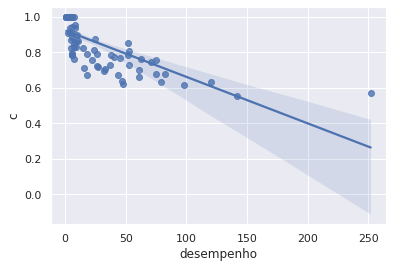

In [69]:
sns.regplot(x=df_desempenho_cluster['desempenho'], y=df_desempenho_cluster['c'])
plt.show()

### Análise com variáveis de controle

#### Desempenho X (Clustering Coefficient + GDP)

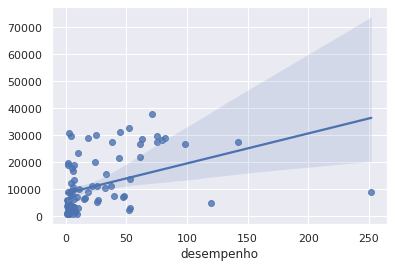

In [70]:
sns.regplot(x=df_desempenho_cluster['desempenho'], y=(df_desempenho_cluster['c'] + (df_desempenho_cluster['y'])))
plt.show()

In [71]:
model = smf.ols(data=df_desempenho_cluster, formula='desempenho ~ y+c+pop')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     41.94
Date:                Sat, 27 Nov 2021   Prob (F-statistic):           8.52e-17
Time:                        01:10:47   Log-Likelihood:                -413.18
No. Observations:                  90   AIC:                             834.4
Df Residuals:                      86   BIC:                             844.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    169.5572     20.165      8.408      0.000     129.470     209.645
y              0.0007      0.000      2.503      0.014       0.000       0.001
c           -180.5025     21.326     -8.464      0.000    -222.898    -138.107
pop         3.863e-08   1.47e-08      2.620      0.010    9.32e-09    6.79e-08
==============================================================================
Omnibus:                      117.963   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3404.343
Skew:                           4.200   Prob(JB):                         0.00
Kurtosis:                      31.935   Cond. No.                     2.14e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.14e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Recorte temporal: 1970-1990

### Carrega dados
---

In [72]:
#carrega dados
df = pd.read_csv('athlete_events.csv')
df_noc = pd.read_csv('noc_regions.csv')
df_gdp = pd.read_csv('countries of the world.csv')

In [73]:
#junta ambas as tabelas
df_merge=df.merge(df_noc,how="left",on="NOC")

#dropa linhas sem a região
df_merge=df_merge.dropna(subset=['region'])

### Amostragem
---

In [74]:
#filtra somente datas posteriores a 1970
df_merge_before=df_merge[df_merge["Year"] >= 1970]
df_merge_before=df_merge_before[df_merge_before["Year"] <= 1990]

### Análise
---

In [75]:
#cria grafo não-dirigido
g = Graph(directed=False)
c = Graph(directed=False) 

In [76]:
df_merge_before['desempenho'] = df_merge_before['Medal'].apply(lambda x: desempenho(x))

#dropa valores duplicados
df_desempenho = df_merge_before.drop_duplicates(subset=["Year","Sport","region"])

#remove paises com desempenho 0
df_desempenho = df_desempenho.loc[df_desempenho.desempenho>0]

#pega o desempenho por país por esporte
df_desempenho_pais = df_desempenho[["Sport", "region", "desempenho"]].groupby(["Sport", "region"], as_index=False).sum()

#calcula o desemepnho médio por esporte
df_desempenho_media = df_desempenho_pais.groupby(["Sport"]).mean()

#adiciona o desempenho médio por esporte na tabela
df_desempenho_pais["media"] = df_desempenho_pais["Sport"].apply(lambda x: 
              media(x, df_desempenho_media))

#ajusta nome dos países na tabela
df_gdp['Country'] = df_gdp['Country'].apply(lambda x: elimina_ultimo_caracter(x))

#dicionário com os nomes corretos
dic_paises_nome = {
    'South Korea': 'Korea, South',
    'USA': 'United States',
    'UK': 'United Kingdom',
    'North Korea': 'Korea, North',
    'Ivory Coast': "Cote d'Ivoire"
}

#acerta o nome dos países
df_desempenho_pais['region'] = df_desempenho_pais['region'].apply(lambda x: acerta_nome_paises(x, dic_paises_nome)) 

#pega informações sobre cada país
df_desempenho_pais = df_desempenho_pais.merge(df_gdp[["Country","GDP ($ per capita)"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country",)

#remove alguns países irrelevantes
df_desempenho_pais = df_desempenho_pais.dropna(subset=['GDP ($ per capita)'])



In [77]:
df_desempenho_pais.head()

,Sport,region,desempenho,media,Country,GDP ($ per capita)
0,Alpine Skiing,Czech Republic,1,1.50,Czech Republic,15700.0
1,Alpine Skiing,Switzerland,2,1.50,Switzerland,32700.0
2,Archery,Finland,1,2.25,Finland,27400.0
3,Archery,Japan,2,2.25,Japan,28200.0
4,Archery,Russia,3,2.25,Russia,8900.0


In [78]:
# mudar a cor de fundo do grafo
r.graph(color=0xffffff)

# mudar a cor e o tamanho dos vértices
r.vertex_default(color=0x05445E, size=15)

# mudar a cor, a espessura e a curvatura das arestas
r.edge_default(color=0xB1D4E0, width=1, curve1=0, curve2=0)

r.graph(kscale=5) # Isto aumenta o tamanho dos nomes.
r.vertex_default(size=6)
r.vertex_set_key('nome')
r.edge_scale('peso', 1, 3)




## Grupo

In [79]:
# separando por grupos
df_desempenho_group = df_desempenho[df_desempenho['Event'].isin(group_events)]

df_desempenho_pais_total_gp = df_desempenho_group[["region", "desempenho"]].groupby(["region"], as_index=False).sum()



# Separando as informações importantes
df_desempenho_pais_total_gp = df_desempenho_pais_total_gp.merge(df_gdp[["Country","GDP ($ per capita)"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country")

df_desempenho_pais_total_gp = df_desempenho_pais_total_gp.merge(dft,
                                              how='left',
                                              left_on="region",
                                              right_on="nome")

df_desempenho_pais_total_gp = df_desempenho_pais_total_gp.merge(df_gdp[["Country","Population"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country",)

df_desempenho_pais_total_gp['y'] = df_desempenho_pais_total_gp['GDP ($ per capita)']
df_desempenho_pais_total_gp['c'] = df_desempenho_pais_total_gp['clustering coefficient']
df_desempenho_pais_total_gp['pop'] = df_desempenho_pais_total_gp['Population']

In [80]:
model = smf.ols(data=df_desempenho_pais_total_gp, formula='desempenho ~ y')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.8330
Date:                Sat, 27 Nov 2021   Prob (F-statistic):              0.370
Time:                        01:10:49   Log-Likelihood:                -105.48
No. Observations:                  28   AIC:                             215.0
Df Residuals:                      26   BIC:                             217.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.9072      3.691      2.684      0.012       2.320      17.494
y             -0.0002      0.000     -0.913      0.370      -0.001       0.000
==============================================================================
Omnibus:                       45.878   Durbin-Watson:                   1.695
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              198.582
Skew:                           3.239   Prob(JB):                     7.56e-44
Kurtosis:                      14.325   Cond. No.                     3.61e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

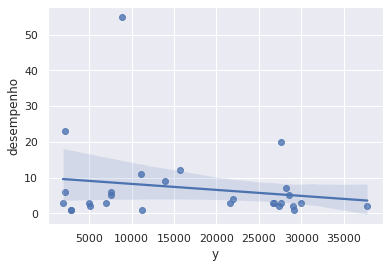

In [81]:
sns.regplot(x=df_desempenho_pais_total_gp['y'], y=(df_desempenho_pais_total_gp['desempenho']))
plt.show()

In [82]:
df_desempenho_cluster = df_desempenho_pais_total_gp.dropna(subset=['clustering coefficient'])

### Grupo - antes de 90


In [83]:
model = smf.ols(data=df_desempenho_cluster, formula='desempenho ~ y+c+pop')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     2.561
Date:                Sat, 27 Nov 2021   Prob (F-statistic):             0.0786
Time:                        01:10:49   Log-Likelihood:                -102.03
No. Observations:                  28   AIC:                             212.1
Df Residuals:                      24   BIC:                             217.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     44.4604     13.928      3.192      0.004      15.715      73.206
y             -0.0004      0.000     -1.976      0.060      -0.001    1.68e-05
c            -40.6747     16.404     -2.480      0.021     -74.531      -6.818
pop        -5.256e-09    6.6e-09     -0.797      0.433   -1.89e-08    8.36e-09
==============================================================================
Omnibus:                       32.578   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.754
Skew:                           2.265   Prob(JB):                     1.96e-20
Kurtosis:                      10.568   Cond. No.                     3.72e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.72e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Individual

In [84]:
# separando por grupos
df_desempenho_ind = df_desempenho[df_desempenho['Event'].isin(individual_events)]

df_desempenho_pais_total_indv = df_desempenho_ind[["region", "desempenho"]].groupby(["region"], as_index=False).sum()



# Separando as informações importantes
df_desempenho_pais_total_indv = df_desempenho_pais_total_indv.merge(df_gdp[["Country","GDP ($ per capita)"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country")

df_desempenho_pais_total_indv = df_desempenho_pais_total_indv.merge(dft,
                                              how='left',
                                              left_on="region",
                                              right_on="nome")

df_desempenho_pais_total_indv = df_desempenho_pais_total_indv.merge(df_gdp[["Country","Population"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country",)

df_desempenho_pais_total_indv['y'] = df_desempenho_pais_total_indv['GDP ($ per capita)']
df_desempenho_pais_total_indv['c'] = df_desempenho_pais_total_indv['clustering coefficient']
df_desempenho_pais_total_indv['pop'] = df_desempenho_pais_total_indv['Population']

In [85]:
m = draw_gt.sfdp_layout(c)
move_gt(c, m)

In [86]:
save_gt(c, 'exemplo_c.net.gz')

In [87]:
model = smf.ols(data=df_desempenho_pais_total_indv, formula='desempenho ~ y')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     2.306
Date:                Sat, 27 Nov 2021   Prob (F-statistic):              0.136
Time:                        01:10:49   Log-Likelihood:                -186.95
No. Observations:                  47   AIC:                             377.9
Df Residuals:                      45   BIC:                             381.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.6128      3.153      1.780      0.082      -0.738      11.963
y              0.0003      0.000      1.519      0.136    -8.2e-05       0.001
==============================================================================
Omnibus:                       61.296   Durbin-Watson:                   1.684
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              419.075
Skew:                           3.385   Prob(JB):                     9.98e-92
Kurtosis:                      15.968   Cond. No.                     3.12e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

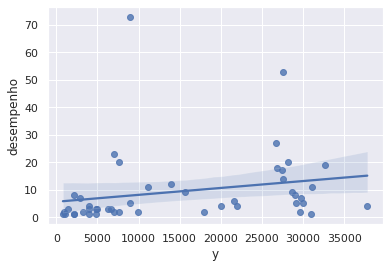

In [88]:
sns.regplot(x=df_desempenho_pais_total_indv['y'], y=(df_desempenho_pais_total_indv['desempenho']))
plt.show()

__________________
----------------------------------

In [89]:
df_desempenho_pais_filtered = df_desempenho_pais_total_indv[df_desempenho_pais_total_indv['desempenho']>30]
df_desempenho_pais_filtered

,region,desempenho,Country_x,GDP ($ per capita),nome,_x,_y,clustering coefficient,Country_y,Population,y,c,pop
15,Germany,53,Germany,27600.0,Germany,8.825891,3.397453,0.551660,Germany,82422299.0,27600.0,0.551660,82422299.0
39,Russia,73,Russia,8900.0,Russia,7.960774,4.654256,0.571917,Russia,142893540.0,8900.0,0.571917,142893540.0
49,USA,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
df_desempenho_pais_filtered = df_desempenho_pais_total_gp[df_desempenho_pais_total_gp['desempenho']>20]
df_desempenho_pais_filtered

,region,desempenho,Country_x,GDP ($ per capita),nome,_x,_y,clustering coefficient,Country_y,Population,y,c,pop
24,Russia,55,Russia,8900.0,Russia,7.960774,4.654256,0.571917,Russia,142893540.0,8900.0,0.571917,142893540.0
25,Serbia,23,Serbia,2200.0,Serbia,8.518582,5.370699,0.784021,Serbia,9396411.0,2200.0,0.784021,9396411.0
30,USA,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
df_desempenho_cluster = df_desempenho_pais_total_indv.dropna(subset=['clustering coefficient'])

## Individuais - antes de 90

In [92]:
model = smf.ols(data=df_desempenho_cluster, formula='desempenho ~ y+c+pop')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     9.007
Date:                Sat, 27 Nov 2021   Prob (F-statistic):           9.57e-05
Time:                        01:10:49   Log-Likelihood:                -176.67
No. Observations:                  47   AIC:                             361.3
Df Residuals:                      43   BIC:                             368.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     61.3696     11.888      5.162      0.000      37.396      85.343
y           6.366e-06      0.000      0.043      0.966      -0.000       0.000
c            -64.4944     13.305     -4.847      0.000     -91.326     -37.663
pop        -1.067e-08   8.92e-09     -1.196      0.238   -2.87e-08    7.32e-09
==============================================================================
Omnibus:                       48.903   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              244.218
Skew:                           2.604   Prob(JB):                     9.30e-54
Kurtosis:                      12.878   Cond. No.                     2.25e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.25e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

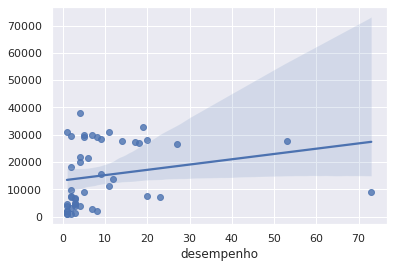

In [93]:
sns.regplot(x=df_desempenho_cluster['desempenho'], y=(df_desempenho_cluster['c'] + (df_desempenho_cluster['y'])))
plt.show()

# Recorte temporal: 2000-2017

### Carrega dados
---

In [94]:
#carrega dados
df = pd.read_csv('athlete_events.csv')
df_noc = pd.read_csv('noc_regions.csv')
df_gdp = pd.read_csv('countries of the world.csv')

In [95]:
#junta ambas as tabelas
df_merge=df.merge(df_noc,how="left",on="NOC")

#dropa linhas sem a região
df_merge=df_merge.dropna(subset=['region'])

### Amostragem
---

In [96]:
#filtra somente datas posteriores a 1970
df_merge_after=df_merge[df_merge["Year"] >= 2000]

### Análise
---

In [97]:
#cria grafo não-dirigido
g = Graph(directed=False)
c = Graph(directed=False) 

In [98]:
df_merge_after['desempenho'] = df_merge_after['Medal'].apply(lambda x: desempenho(x))

#dropa valores duplicados
df_desempenho = df_merge_after.drop_duplicates(subset=["Year","Sport","region"])

#remove paises com desempenho 0
df_desempenho = df_desempenho.loc[df_desempenho.desempenho>0]

#pega o desempenho por país por esporte
df_desempenho_pais = df_desempenho[["Sport", "region", "desempenho"]].groupby(["Sport", "region"], as_index=False).sum()

#calcula o desemepnho médio por esporte
df_desempenho_media = df_desempenho_pais.groupby(["Sport"]).mean()

#adiciona o desempenho médio por esporte na tabela
df_desempenho_pais["media"] = df_desempenho_pais["Sport"].apply(lambda x: 
              media(x, df_desempenho_media))

#ajusta nome dos países na tabela
df_gdp['Country'] = df_gdp['Country'].apply(lambda x: elimina_ultimo_caracter(x))

#dicionário com os nomes corretos
dic_paises_nome = {
    'South Korea': 'Korea, South',
    'USA': 'United States',
    'UK': 'United Kingdom',
    'North Korea': 'Korea, North',
    'Ivory Coast': "Cote d'Ivoire"
}

#acerta o nome dos países
df_desempenho_pais['region'] = df_desempenho_pais['region'].apply(lambda x: acerta_nome_paises(x, dic_paises_nome)) 

#pega informações sobre cada país
df_desempenho_pais = df_desempenho_pais.merge(df_gdp[["Country","GDP ($ per capita)"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country",)

#remove alguns países irrelevantes
df_desempenho_pais = df_desempenho_pais.dropna(subset=['GDP ($ per capita)'])


#pega todos os times
lista_teams = df_desempenho_pais.region.unique().tolist()

#pega todos os eventos
lista_eventos = df_desempenho_pais.Sport.unique().tolist()

g.vp['tipo'] = g.new_vp('object')
g.vp['nome'] = g.new_vp('object')
g.vp['color'] = g.new_vp('object')

lista_vertices = lista_teams+lista_eventos

#cria os times como vértices
cria_vertices(g, lista_vertices, len(lista_teams))
print('número de vértices de g:', g.num_vertices())

lista_arestas = list()

#preenche a lista e o dicionario de acordo com as partidas e ocorrencias
df_fake = df_desempenho_pais.apply(lambda x: 
              arestas(x.region, x.Sport, x.desempenho, x.media, lista_arestas),
              axis=1)

create_edgs_links(lista_arestas, g)


c.vp['nome'] = c.new_vp('object') #adiciona propriedade aos vértices
c.ep['peso'] = c.new_ep('object') #adiciona propriedade as arestas

cria_nome_times(g, c) #cria vertíces

dicionario_one_mode, lista_one_mode = lista_esporte_por_time(g)

dist = cria_arestas(c, dicionario_one_mode, lista_one_mode)


número de vértices de g: 134


## Esportes em grupo

In [99]:
# separando por grupos
df_desempenho_group = df_desempenho[df_desempenho['Event'].isin(group_events)]

df_desempenho_pais_total_gp = df_desempenho_group[["region", "desempenho"]].groupby(["region"], as_index=False).sum()



# Separando as informações importantes
df_desempenho_pais_total_gp = df_desempenho_pais_total_gp.merge(df_gdp[["Country","GDP ($ per capita)"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country")

df_desempenho_pais_total_gp = df_desempenho_pais_total_gp.merge(dft,
                                              how='left',
                                              left_on="region",
                                              right_on="nome")

df_desempenho_pais_total_gp = df_desempenho_pais_total_gp.merge(df_gdp[["Country","Population"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country",)

df_desempenho_pais_total_gp['y'] = df_desempenho_pais_total_gp['GDP ($ per capita)']
df_desempenho_pais_total_gp['c'] = df_desempenho_pais_total_gp['clustering coefficient']
df_desempenho_pais_total_gp['pop'] = df_desempenho_pais_total_gp['Population']

In [100]:
df_desempenho_pais_total_gp.head()

,region,desempenho,Country_x,GDP ($ per capita),nome,_x,_y,clustering coefficient,Country_y,Population,y,c,pop
0,Argentina,16,Argentina,11200.0,Argentina,7.673247,6.228421,0.792075,Argentina,39921833.0,11200.0,0.792075,39921833.0
1,Australia,18,Australia,29000.0,Australia,10.696573,4.080148,0.679000,Australia,20264082.0,29000.0,0.679000,20264082.0
2,Belgium,2,Belgium,29100.0,Belgium,11.922714,6.839597,0.787561,Belgium,10379067.0,29100.0,0.787561,10379067.0
3,Brazil,21,Brazil,7600.0,Brazil,9.598687,6.502751,0.770852,Brazil,188078227.0,7600.0,0.770852,188078227.0
4,Cameroon,3,Cameroon,1800.0,Cameroon,4.897598,7.724919,1.000000,Cameroon,17340702.0,1800.0,1.000000,17340702.0


In [101]:
model = smf.ols(data=df_desempenho_pais_total_gp, formula='desempenho ~ y')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1.750
Date:                Sat, 27 Nov 2021   Prob (F-statistic):              0.195
Time:                        01:10:52   Log-Likelihood:                -112.42
No. Observations:                  34   AIC:                             228.8
Df Residuals:                      32   BIC:                             231.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.4210      2.197      2.923      0.006       1.947      10.895
y              0.0001      0.000      1.323      0.195   -7.55e-05       0.000
==============================================================================
Omnibus:                        2.989   Durbin-Watson:                   2.402
Prob(Omnibus):                  0.224   Jarque-Bera (JB):                2.730
Skew:                           0.647   Prob(JB):                        0.255
Kurtosis:                       2.500   Cond. No.                     3.91e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.91e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

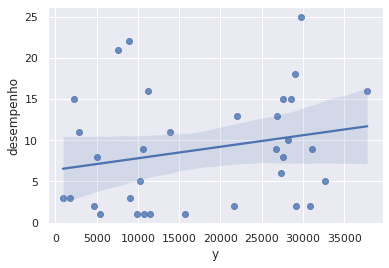

In [102]:
sns.regplot(x=df_desempenho_pais_total_gp['y'], y=(df_desempenho_pais_total_gp['desempenho']))
plt.show()

In [103]:
df_desempenho_cluster = df_desempenho_pais_total_gp.dropna(subset=['clustering coefficient'])

### Grupo - depois de 90


In [104]:
model = smf.ols(data=df_desempenho_cluster, formula='desempenho ~ y+c+pop')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     2.917
Date:                Sat, 27 Nov 2021   Prob (F-statistic):             0.0503
Time:                        01:10:53   Log-Likelihood:                -108.97
No. Observations:                  34   AIC:                             225.9
Df Residuals:                      30   BIC:                             232.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.9687      8.674      3.109      0.004       9.253      44.684
y            6.91e-05      0.000      0.644      0.524      -0.000       0.000
c            -25.1555     10.009     -2.513      0.018     -45.597      -4.715
pop        -1.186e-09    5.4e-09     -0.220      0.828   -1.22e-08    9.83e-09
==============================================================================
Omnibus:                        2.637   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.268   Jarque-Bera (JB):                1.986
Skew:                           0.592   Prob(JB):                        0.370
Kurtosis:                       2.982   Cond. No.                     2.81e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.81e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Esportes individuais

In [105]:
# separando por grupos
df_desempenho_ind = df_desempenho[df_desempenho['Event'].isin(individual_events)]

df_desempenho_pais_total_indv = df_desempenho_ind[["region", "desempenho"]].groupby(["region"], as_index=False).sum()



# Separando as informações importantes
df_desempenho_pais_total_indv = df_desempenho_pais_total_indv.merge(df_gdp[["Country","GDP ($ per capita)"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country")

df_desempenho_pais_total_indv = df_desempenho_pais_total_indv.merge(dft,
                                              how='left',
                                              left_on="region",
                                              right_on="nome")

df_desempenho_pais_total_indv = df_desempenho_pais_total_indv.merge(df_gdp[["Country","Population"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country",)

df_desempenho_pais_total_indv['y'] = df_desempenho_pais_total_indv['GDP ($ per capita)']
df_desempenho_pais_total_indv['c'] = df_desempenho_pais_total_indv['clustering coefficient']
df_desempenho_pais_total_indv['pop'] = df_desempenho_pais_total_indv['Population']

In [106]:
model = smf.ols(data=df_desempenho_pais_total_indv, formula='desempenho ~ y')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     8.324
Date:                Sat, 27 Nov 2021   Prob (F-statistic):            0.00512
Time:                        01:10:53   Log-Likelihood:                -307.51
No. Observations:                  76   AIC:                             619.0
Df Residuals:                      74   BIC:                             623.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8945      2.543      2.318      0.023       0.827      10.962
y              0.0005      0.000      2.885      0.005       0.000       0.001
==============================================================================
Omnibus:                       88.452   Durbin-Watson:                   2.199
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              991.760
Skew:                           3.623   Prob(JB):                    4.39e-216
Kurtosis:                      19.146   Cond. No.                     2.54e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.54e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

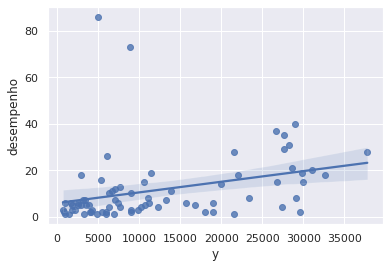

In [107]:
sns.regplot(x=df_desempenho_pais_total_indv['y'], y=(df_desempenho_pais_total_indv['desempenho']))
plt.show()

In [108]:
df_desempenho_pais_filtered = df_desempenho_pais_total_indv[df_desempenho_pais_total_indv['desempenho']>30]
df_desempenho_pais_filtered

,region,desempenho,Country_x,GDP ($ per capita),nome,_x,_y,clustering coefficient,Country_y,Population,y,c,pop
3,Australia,40,Australia,29000.0,Australia,10.696573,4.080148,0.679000,Australia,2.026408e+07,29000.0,0.679000,2.026408e+07
13,China,86,China,5000.0,China,10.026358,4.236053,0.635322,China,1.313974e+09,5000.0,0.635322,1.313974e+09
24,France,35,France,27600.0,France,10.002945,5.668561,0.679974,France,6.087614e+07,27600.0,0.679974,6.087614e+07
35,Italy,37,Italy,26700.0,Italy,7.712542,5.379419,0.617784,Italy,5.813351e+07,26700.0,0.617784,5.813351e+07
38,Japan,31,Japan,28200.0,Japan,8.610238,4.094047,0.633642,Japan,1.274636e+08,28200.0,0.633642,1.274636e+08
59,Russia,73,Russia,8900.0,Russia,7.960774,4.654256,0.571917,Russia,1.428935e+08,8900.0,0.571917,1.428935e+08
75,UK,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,USA,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
df_desempenho_pais_filtered = df_desempenho_pais_total_gp[df_desempenho_pais_total_gp['desempenho']>20]
df_desempenho_pais_filtered

,region,desempenho,Country_x,GDP ($ per capita),nome,_x,_y,clustering coefficient,Country_y,Population,y,c,pop
3,Brazil,21,Brazil,7600.0,Brazil,9.598687,6.502751,0.770852,Brazil,188078227.0,7600.0,0.770852,188078227.0
5,Canada,25,Canada,29800.0,Canada,8.469009,6.021204,0.756942,Canada,33098932.0,29800.0,0.756942,33098932.0
28,Russia,22,Russia,8900.0,Russia,7.960774,4.654256,0.571917,Russia,142893540.0,8900.0,0.571917,142893540.0
36,USA,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
df_desempenho_cluster = df_desempenho_pais_total_indv.dropna(subset=['clustering coefficient'])

## Individuais - depois de 90

In [111]:
model = smf.ols(data=df_desempenho_cluster, formula='desempenho ~ y+c+pop')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     38.58
Date:                Sat, 27 Nov 2021   Prob (F-statistic):           9.36e-15
Time:                        01:10:53   Log-Likelihood:                -263.99
No. Observations:                  73   AIC:                             536.0
Df Residuals:                      69   BIC:                             545.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     58.0213      8.238      7.043      0.000      41.588      74.455
y              0.0003      0.000      2.626      0.011    7.28e-05       0.001
c            -62.6543      9.007     -6.956      0.000     -80.623     -44.686
pop         3.285e-08   5.64e-09      5.830      0.000    2.16e-08    4.41e-08
==============================================================================
Omnibus:                       34.904   Durbin-Watson:                   2.294
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              157.505
Skew:                           1.251   Prob(JB):                     6.28e-35
Kurtosis:                       9.747   Cond. No.                     2.33e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.33e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""